# Contextual Bandits Agent with Policy Gradient Method (Deterministic) in Prediction Markets Problem
---
This is a program that simulates an agent who trades in a prediction market. The problem that the prediction market aims to solve is to predict the real distribution of a random variable. We define the random variable as the colour of a bucket. The problem design comes from a human-subjective experiment for decision markets.

In [1]:
import matplotlib.pyplot as plt
import traceback
from tqdm.notebook import tnrange
import pandas as pd

In [2]:
from scipy.special import logit, expit
from PolicyGradientAgent import DeterministicGradientAgent
from Environment import *

In [76]:
learning_rate_theta = 1e-4
decay_rate = 0 #0.001
learning_rate_wv = 1e-5
learning_rate_wq = 1e-2
memory_size = 16
batch_size = 16
training_episodes = 900000
beta1 = 0.9
beta2 = 0.9999
# Algorithm: adam, momentum, regular
algorithm = 'regular'
# Bucket parameters
prior_red_list = [2/3, 1/3]
pr_red_ball_red_bucket = 2/3
pr_red_ball_blue_bucket = 1/3

agent = DeterministicGradientAgent(
    feature_shape=[1, 3], 
    learning_rate_theta=learning_rate_theta,
    learning_rate_wv = learning_rate_wv,
    learning_rate_wq=learning_rate_wq, 
    memory_size= memory_size, 
    batch_size=batch_size,
    beta1=beta1, 
    beta2=beta2
)

explorer = Explorer(feature_shape=[1, 3], learning= False, init_learning_rate=3e-4)


reward_history_list = []
average_reward = 0
average_actual_reward = 0


mean_weights_history_list = []

r_ball_mean_history_list = []
b_ball_mean_history_list = []


r_ball_pred_history_list = []
b_ball_pred_history_list = []

grad_r_ball_mean_history_list = []
grad_b_ball_mean_history_list = []


grad_r_ball_v_mean_history_list = []
grad_b_ball_v_mean_history_list = []


grad_r_ball_adam_mean_history_list = []
grad_b_ball_adam_mean_history_list = []

explorer_std_list = []

grad_mean_history_list = []
grad_v_history_list = []
grad_q_history_list = []
mean_history_list = []
actual_report_history_list = []


for t in tnrange(training_episodes):
    prior_red = np.random.choice(prior_red_list)
    # Prepare a bucket and a prediction market
    bucket = Bucket(prior_red, pr_red_ball_red_bucket, pr_red_ball_blue_bucket)
    pm = PredictionMarket(prior_red=prior_red)
    signal = bucket.signal()
    x = one_hot_encode(signal)
    x.append(logit(prior_red))

    mean = agent.report(x)
    pi = expit(mean)
    actual_report = [pi, 1-pi]
    explorer.set_parameters(mean=mean, std=0.5)
    noised_report = explorer.report(x)
#     _pi = np.random.uniform() # uniform doesn't work, reason unknown.
#     noised_report = [_pi, 1-_pi]
    
    explorer_std_list.append(explorer.std)

    pm.report(noised_report)
    R = pm.log_resolve(bucket_colour_to_num[bucket.colour])
    
    pm.report(actual_report)
    actual_R = pm.log_resolve(bucket_colour_to_num[bucket.colour])


    average_reward = average_reward + (1/ (t + 1)) * (R - average_reward)
    average_actual_reward = average_actual_reward + (1/ (t + 1)) * (actual_R - average_actual_reward)
    
    mean_weights_history_list.append(agent.theta_mean[0].tolist())   

    actual_pr_ru_S = 0
    expected_log_reward = 0
    max_expected_log_reward = 0
    regret = 0
    if signal == 'red':
        actual_pr_ru_S = analytical_best_report_ru_rs(pr_ru=prior_red, pr_rs_ru=pr_red_ball_red_bucket, pr_rs_bu=pr_red_ball_blue_bucket)
        expected_log_reward = expected_log_reward_red_ball(actual_pr_ru_rs=actual_pr_ru_S, estimated_pr_ru_rs=pi, pr_ru=prior_red)
        max_expected_log_reward = expected_log_reward_red_ball(actual_pr_ru_rs=actual_pr_ru_S, estimated_pr_ru_rs=actual_pr_ru_S, pr_ru=prior_red)
    else:
        actual_pr_ru_S = analytical_best_report_ru_bs(pr_ru=prior_red, pr_bs_ru=1-pr_red_ball_red_bucket, pr_bs_bu=1-pr_red_ball_blue_bucket)
        expected_log_reward = expected_log_reward_blue_ball(actual_pr_ru_bs=actual_pr_ru_S, estimated_pr_ru_bs=pi, pr_ru=prior_red)
        max_expected_log_reward = expected_log_reward_blue_ball(actual_pr_ru_bs=actual_pr_ru_S, estimated_pr_ru_bs=actual_pr_ru_S, pr_ru=prior_red)
    

    action = logit(noised_report[0])
    agent.store_experience(x, action, R, t)

    explorer.update(R, x)

    try:
        grad_mean, \
        gradient_v, \
        gradient_q, \
        v_dw_mean_corrected, \
        s_dw_mean_corrected, \
        v, q = agent.batch_update(t, algorithm= algorithm)
    except AssertionError:
        tb = traceback.format_exc()
        print(tb)
    
    
    agent.learning_rate_decay(epoch=t, decay_rate=decay_rate)
    if explorer.learning:
        explorer.learning_rate_decay(epoch=t, decay_rate=0.001)
        
    
    reward_history_list.append([R, average_reward, actual_R, average_actual_reward, max_expected_log_reward - expected_log_reward, v, q, signal])
        
    if signal == 'red':
        r_ball_pred_history_list.append(noised_report[0])
        r_ball_mean_history_list.append(mean)      
    else:
        b_ball_pred_history_list.append(noised_report[0])
        b_ball_mean_history_list.append(mean)
        
    actual_report_history_list.append([actual_report[0], signal])
    mean_history_list.append([mean, signal])
    grad_mean_history_list.append(grad_mean[0, :])    
    grad_v_history_list.append(gradient_v[0, :])
    grad_q_history_list.append(gradient_q[0, :])
        
    grad_r_ball_mean_history_list.append(grad_mean[0, 0])
    ##########
    grad_r_ball_v_mean_history_list.append(v_dw_mean_corrected[0, 0])
    grad_r_ball_adam_mean_history_list.append(s_dw_mean_corrected[0, 0])
    
    grad_b_ball_mean_history_list.append(grad_mean[0, 1])
    #########
    grad_b_ball_v_mean_history_list.append(v_dw_mean_corrected[0, 1])
    grad_b_ball_adam_mean_history_list.append(s_dw_mean_corrected[0, 1])        

  0%|          | 0/900000 [00:00<?, ?it/s]

learning_rate_theta= 0.0001  learning_rate_wq= 0.01
memory_size= 16
Updating weights with regular algorithm.


In [77]:
reward_history_df = pd.DataFrame(
    reward_history_list, 
    columns=[
        'noised_reward', 
        'noised_average_reward', 
        'actual_reward', 
        'average_actual_reward',
        'regret',
        'v',
        'q',
        'signal'
    ]
)


mean_weights_history_df = pd.DataFrame(mean_weights_history_list, columns=['red_weight', 'blue_weight', 'prior_weight'])


grad_r_ball_mean_history = np.array(grad_r_ball_mean_history_list)
grad_b_ball_mean_history = np.array(grad_b_ball_mean_history_list)


grad_r_ball_v_mean_history = np.array(grad_r_ball_v_mean_history_list)
grad_b_ball_v_mean_history = np.array(grad_b_ball_v_mean_history_list)


grad_r_ball_adam_mean_history = np.array(grad_r_ball_adam_mean_history_list)
grad_b_ball_adam_mean_history = np.array(grad_b_ball_adam_mean_history_list)

grad_mean_history_df = pd.DataFrame(grad_mean_history_list, columns=['red_ball', 'blue_ball', 'prior'])
actual_report_history_df = pd.DataFrame(actual_report_history_list, columns=['report', 'signal'])
mean_history_df = pd.DataFrame(mean_history_list, columns=['mean', 'signal'])
grad_v_history_df = pd.DataFrame(grad_v_history_list, columns=['red_v', 'blue_v', 'prior_v'])
grad_q_history_df = pd.DataFrame(grad_q_history_list, columns=['red_q', 'blue_q', 'prior_q'])

Towards best ratio:  2.872014162779048


Text(0.5, 0.98, 'Actual Rewards and Average')

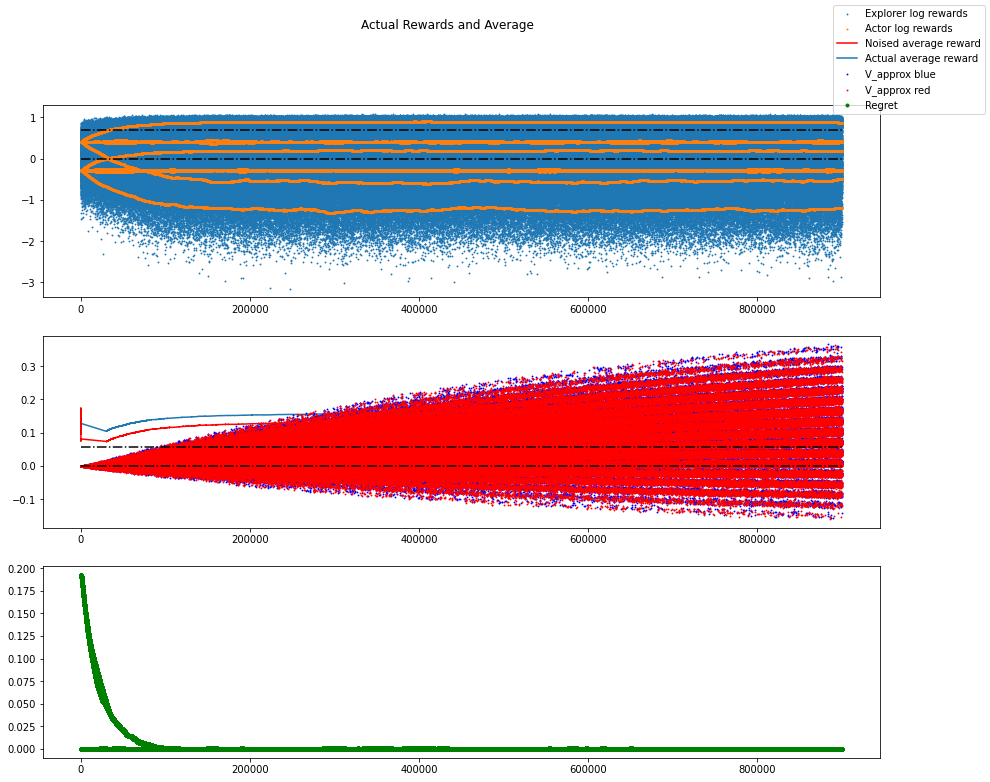

In [106]:
theoretical_best = 2/3*(np.log(2/3)-np.log(1/2)) + 1/3*(np.log(1/3)-np.log(1/2))
empirical_best = reward_history_df.iloc[-100:, 3].mean()
print('Towards best ratio: ', empirical_best/ theoretical_best)
fig, axs = plt.subplots(3, figsize=(15, 12))
axs[0].scatter(x=reward_history_df.index, y=reward_history_df['noised_reward'],label = 'Explorer log rewards', marker='.', s=3, zorder=-100)
axs[0].scatter(x=reward_history_df.index, y=reward_history_df['actual_reward'],label = 'Actor log rewards', marker='.', s=3, zorder=-99)
axs[1].plot(no_outlier_array(reward_history_df.iloc[:, 1]),zorder= -97, label = 'Noised average reward',color='red')
for signal, df in reward_history_df.reset_index().groupby('signal'):
    axs[1].scatter(x=df['index'], y=df.loc[:, 'v'], zorder = -97, label = 'V_approx '+signal, marker='.', c=signal, s=3)
#     axs[1].scatter(x=df['index'], y=df.loc[:, 'q'], zorder= -100, label = 'Q_approx '+signal, marker='.', c=signal, s=3)
axs[1].plot(no_outlier_array(reward_history_df.iloc[:, 3]),zorder= -98, label = 'Actual average reward')
# axs[1].plot(reward_history_df.loc[:, 'average_expected_reward'], zorder= -98, label = 'Averagee expected reward')
axs[2].plot(reward_history_df['regret'], 'g.', label='Regret')
axs[0].hlines(y=np.log(2), xmin=0, xmax=reward_history_df.shape[0], colors='black', linestyles='dashdot')
axs[0].hlines(y=0.0, xmin=0, xmax=reward_history_df.shape[0] , colors='black', linestyles='dashdot')
axs[1].hlines(y=0.0, xmin=0, xmax=reward_history_df.shape[0] , colors='black', linestyles='dashdot')
axs[1].hlines(y=theoretical_best, xmin=0, xmax=reward_history_df.shape[0] , colors='black', linestyles='dashdot')
fig.legend()
fig.suptitle('Actual Rewards and Average')

Text(0.5, 0.98, 'State Estimated Value Gradients')

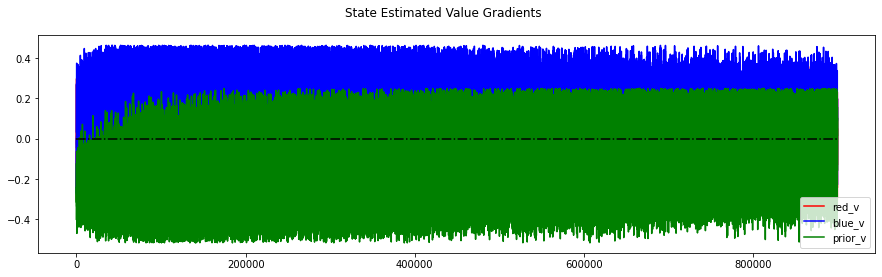

In [79]:
fig, ax = plt.subplots(figsize=(15, 4))
no_outlier_df(grad_v_history_df).plot(ax=ax, color=['red', 'blue', 'green'], zorder=-99)
ax.hlines(y=0, xmin=0, xmax=len(grad_v_history_df), linestyles='dashdot', zorder=-98, color='black')
# for coord in phase_change_coordinates(mark_index, grad_mean_history_df):
#     plt.annotate('change', xy=coord, xytext=(coord[0], coord[1] + 0.06), arrowprops=dict(arrowstyle="->"))
fig.suptitle("State Estimated Value Gradients")

In [80]:
grad_v_history_df.iloc[-300000:, :].describe()

,red_v,blue_v,prior_v
count,300000.000000,300000.000000,300000.000000
mean,0.023798,0.023061,-0.081068
std,0.119871,0.131167,0.120145
min,-0.958376,-0.848566,-0.788742
25%,-0.034874,-0.054928,-0.159249
50%,0.044810,0.029993,-0.081435
75%,0.104077,0.110045,-0.003059
max,0.377694,0.543616,0.567996


Text(0.5, 0.98, 'State-Action Estimated Value Gradients')

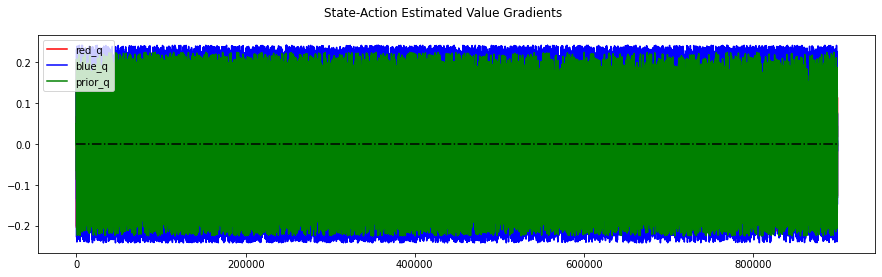

In [81]:
fig, ax = plt.subplots(figsize=(15, 4))
no_outlier_df(grad_q_history_df).plot(ax=ax, color=['red', 'blue', 'green'], zorder=-99)
ax.hlines(y=0, xmin=0, xmax=len(grad_q_history_df), linestyles='dashdot', zorder=-98, color='black')
# for coord in phase_change_coordinates(mark_index, grad_mean_history_df):
#     plt.annotate('change', xy=coord, xytext=(coord[0], coord[1] + 0.06), arrowprops=dict(arrowstyle="->"))
fig.suptitle("State-Action Estimated Value Gradients")

In [82]:
grad_q_history_df.describe()

,red_q,blue_q,prior_q
count,900000.000000,900000.000000,900000.000000
mean,0.000011,-0.000002,-0.000005
std,0.071823,0.080743,0.074979
min,-1.539114,-0.900239,-1.091412
25%,-0.022924,-0.041286,-0.037639
50%,0.005957,-0.000731,0.004474
75%,0.035755,0.038083,0.044506
max,0.634465,1.516917,0.783669


Text(0.5, 1.0, 'Actual Report')

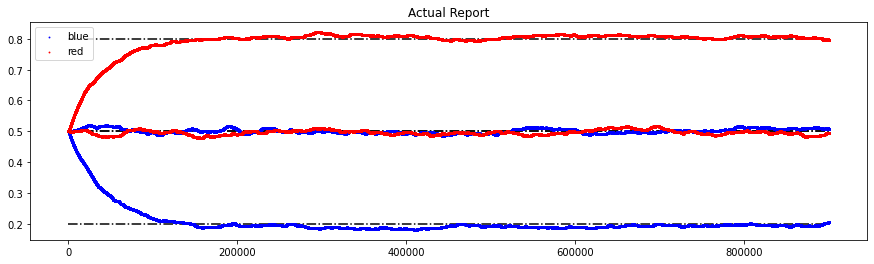

In [107]:
fig, ax = plt.subplots(figsize=(15, 4))
for signal, df in actual_report_history_df.reset_index().groupby('signal'):
    ax.scatter(x=df['index'], y=df['report'], label=signal, marker='.', c=signal, s=3)
for prior_red in prior_red_list:
    plt.hlines(
        y=analytical_best_report_ru_rs(
            pr_ru=prior_red, 
            pr_rs_ru=pr_red_ball_red_bucket, 
            pr_rs_bu=pr_red_ball_blue_bucket
        ), xmin=0, xmax=len(mean_history_df), colors='black', linestyles='dashdot', zorder=-98)

    plt.hlines(
        y=analytical_best_report_ru_bs(
            pr_ru=prior_red, 
            pr_bs_ru=1-pr_red_ball_red_bucket, 
            pr_bs_bu=1-pr_red_ball_blue_bucket
        ), xmin=0, xmax=len(mean_history_df), colors='black', linestyles='dashdot', zorder=-98)
ax.legend()
plt.title('Actual Report')

In [84]:
last_one_third_idx = actual_report_history_df.shape[0]//3
actual_report_history_df.iloc[-last_one_third_idx:, :].groupby('signal').describe()

report                                                              \
           count      mean       std       min       25%       50%       75%   
signal                                                                         
blue    149831.0  0.331379  0.153497  0.184943  0.194137  0.198146  0.501586   
red     150169.0  0.670422  0.153031  0.482188  0.499596  0.801409  0.808419   

                  
             max  
signal            
blue    0.517752  
red     0.815218

450309


Text(0.5, 1.0, 'Report')

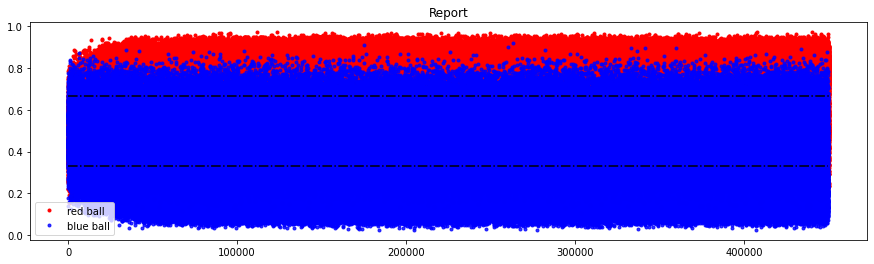

In [85]:
print(len(r_ball_pred_history_list))
fig = plt.figure(figsize=(15, 4))
plt.plot(r_ball_pred_history_list, 'r.', zorder=-100, label='red ball')
plt.plot(b_ball_pred_history_list, 'b.', zorder=-99, label = 'blue ball', alpha=0.8)
plt.hlines(y=2/3, xmin=0, xmax=len(r_ball_pred_history_list), colors='black', linestyles='dashdot')
plt.hlines(y=1/3, xmin=0, xmax=len(b_ball_pred_history_list) , colors='black', linestyles='dashdot')
plt.legend()
plt.title('Report')

In [86]:
print(expit(agent.report([1, 0, 0.5])))

0.7646886144478091


In [87]:
print(expit(agent.report([0, 1, 0.5])))

0.46007704555641143


In [88]:
grad_mean_successive_dot = np.sum(grad_mean_history_df.iloc[:, [1]].values * np.roll(grad_mean_history_df.iloc[:, [1]].values, 1, axis=0), axis=1)[1:]
grad_mean_successive_dot

array([0.        , 0.        , 0.        , ..., 0.0002999 , 0.00030081,
       0.00030121])

In [89]:
(mark_index, ) = np.where(grad_mean_successive_dot < 0)
# mark_index

In [90]:
def phase_change_coordinates(mark_index, df):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    coord_list = []
    prev_x = 0
    for x in mark_index:
        if x > 50:
            if x > prev_x + 2000:
                coord_list.append((x, df.select_dtypes(include=numerics).loc[x, :].max()))
                prev_x = x
    return coord_list

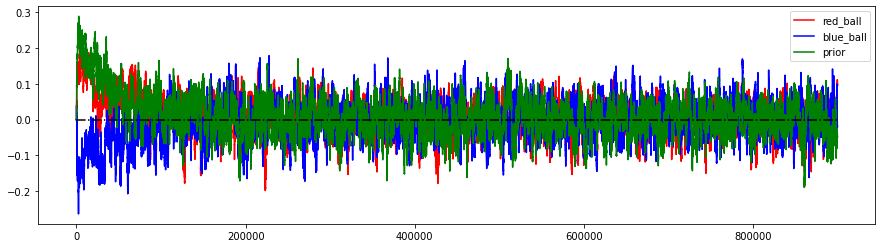

In [91]:
fig, ax = plt.subplots(figsize=(15, 4))
grad_mean_history_df.plot(ax=ax, color=['red', 'blue', 'green'], zorder=-100)
ax.hlines(y=0, xmin=0, xmax=len(grad_mean_history_df), linestyles='dashdot', zorder=-99, color='black')
# for coord in phase_change_coordinates(mark_index, grad_mean_history_df):
#     plt.annotate('change', xy=coord, xytext=(coord[0], coord[1] + 0.06), arrowprops=dict(arrowstyle="->"))

In [92]:
grad_mean_history_df.iloc[-100000:, :].describe()

,red_ball,blue_ball,prior
count,100000.000000,100000.000000,100000.000000
mean,-0.004659,0.002073,-0.004369
std,0.041773,0.045037,0.044794
min,-0.147149,-0.161599,-0.188523
25%,-0.031790,-0.029251,-0.031888
50%,-0.001742,0.001508,-0.004600
75%,0.025276,0.031950,0.026771
max,0.111534,0.141334,0.122195


In [93]:
from scipy.ndimage import uniform_filter1d

Text(0.5, 1.0, 'Successive gradients dot product size 1000 moving average')

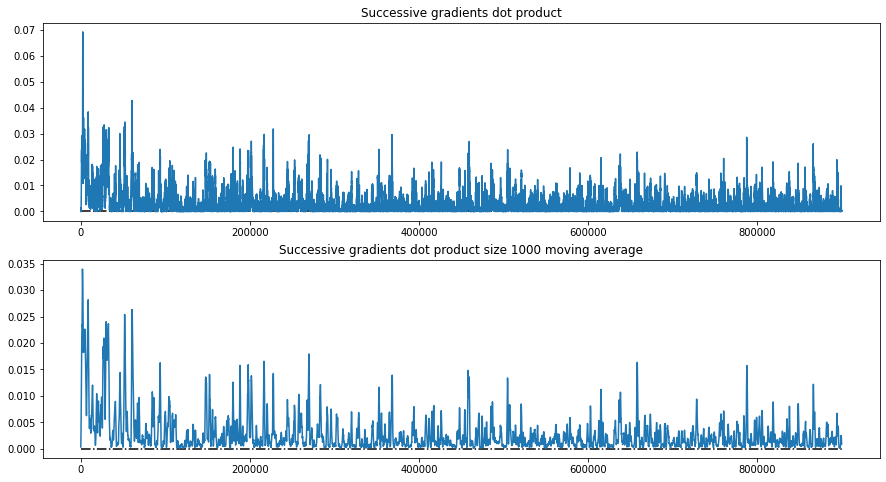

In [94]:
moving_size = 1000
fig, axs = plt.subplots(2, figsize=(15, 8))
axs[0].plot(grad_mean_successive_dot)
axs[0].hlines(y=0, xmin=0, xmax=len(grad_mean_successive_dot), linestyles='dashdot', color='black')
axs[0].set_title('Successive gradients dot product')
axs[1].plot(uniform_filter1d(grad_mean_successive_dot, size=moving_size))
axs[1].hlines(y=0, xmin=0, xmax=len(grad_mean_successive_dot), linestyles='dashdot', color='black')
axs[1].set_title('Successive gradients dot product size %i moving average'%moving_size)

In [95]:
if explorer.learning:
    fig = plt.figure(figsize=(15, 4))
    plt.plot(explorer_std_list)
    plt.title('Explorer Standard Diviation')

In [96]:
import matplotlib.lines as mlines

Text(0.5, 1.0, 'Mean')

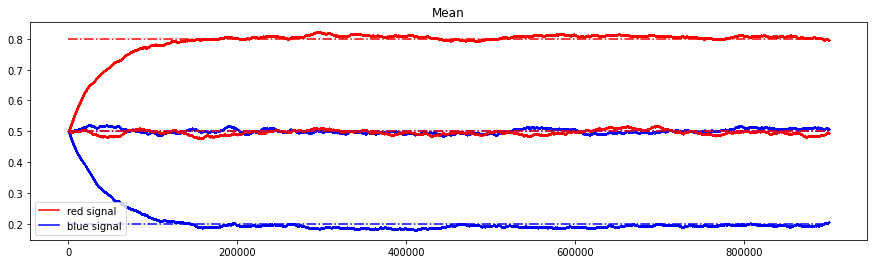

In [108]:
fig, ax = plt.subplots(figsize=(15, 4))
for signal, df in mean_history_df.reset_index().groupby('signal'):
    ax.scatter(x=df['index'], y=expit(df['mean']), label=signal, marker='.', c=signal, alpha=0.6, s=0.1)
for prior_red in prior_red_list:
    plt.hlines(
        y=analytical_best_report_ru_rs(
            pr_ru=prior_red, 
            pr_rs_ru=pr_red_ball_red_bucket, 
            pr_rs_bu=pr_red_ball_blue_bucket
        ), xmin=0, xmax=len(mean_history_df), colors='red', linestyles='dashdot')

    plt.hlines(
        y=analytical_best_report_ru_bs(
            pr_ru=prior_red, 
            pr_bs_ru=1-pr_red_ball_red_bucket, 
            pr_bs_bu=1-pr_red_ball_blue_bucket
        ), xmin=0, xmax=len(mean_history_df), colors='blue', linestyles='dashdot')
red_line = mlines.Line2D([], [], color='red', label='red signal')
blue_line = mlines.Line2D([], [], color='blue', label='blue signal')
# for coord in phase_change_coordinates(mark_index, mean_history_df):
#     plt.annotate('change', xy=coord, xytext=(coord[0], 0.1), arrowprops=dict(arrowstyle="->"))
ax.legend(handles=[red_line, blue_line], loc='lower left')
plt.title('Mean')

In [98]:
mean_history_df.iloc[-last_one_third_idx:, :].groupby('signal').describe()

mean                                                              \
           count      mean       std       min       25%       50%       75%   
signal                                                                         
blue    149831.0 -0.785430  0.713115 -1.483212 -1.423347 -1.397919  0.006345   
red     150169.0  0.794693  0.713374 -0.071279 -0.001614  1.395121  1.439770   

                  
             max  
signal            
blue    0.071037  
red     1.484278

Text(0.5, 1.0, 'Weights for Mean')

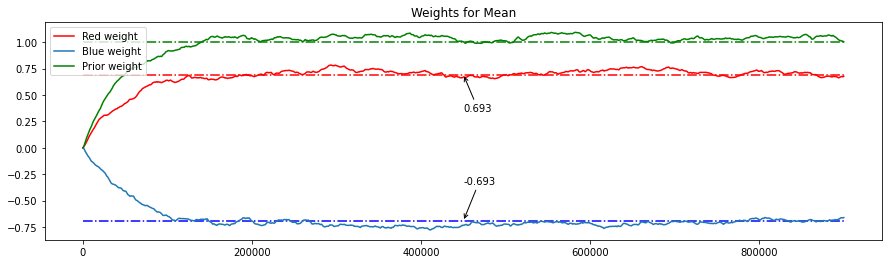

In [109]:
fig = plt.figure(figsize=(15, 4))
plt.plot(mean_weights_history_df.iloc[1:, 0], 'r', label='Red weight')
plt.plot(mean_weights_history_df.iloc[1:, 1], label='Blue weight')
plt.plot(mean_weights_history_df.iloc[1:, 2], 'g', label='Prior weight')
plt.hlines(y=logit(pr_red_ball_red_bucket), xmin=0, xmax=len(mean_weights_history_df), colors='red', linestyles='dashdot')
plt.annotate('%.3f'%logit(pr_red_ball_red_bucket), xy=(len(mean_weights_history_df)/2, logit(pr_red_ball_red_bucket)), xytext=(len(mean_weights_history_df)/2, np.log(2)/2), arrowprops=dict(arrowstyle="->"))
plt.hlines(y=logit(pr_red_ball_blue_bucket), xmin=0, xmax=len(mean_weights_history_df) , colors='blue', linestyles='dashdot')
plt.annotate('%.3f'%logit(pr_red_ball_blue_bucket), xy=(len(mean_weights_history_df)/2, logit(pr_red_ball_blue_bucket)), xytext=(len(mean_weights_history_df)/2, np.log(1/2)/2), arrowprops=dict(arrowstyle="->"))
plt.hlines(y=1, xmin=0, xmax=len(mean_weights_history_df) , colors='green', linestyles='dashdot')
# for coord in phase_change_coordinates(mark_index, mean_weights_history_df):
#     plt.annotate('change', xy=coord, xytext=(coord[0], 0.1), arrowprops=dict(arrowstyle="->"))
plt.legend(loc='upper left')
plt.title('Weights for Mean')

In [100]:
query_index = mean_weights_history_df.shape[0]//3
mean_weights_history_df.iloc[-query_index:, :].describe()

,red_weight,blue_weight,prior_weight
count,300000.000000,300000.000000,300000.000000
mean,0.715558,-0.704484,1.034755
std,0.027897,0.022204,0.016629
min,0.661507,-0.763629,0.991350
25%,0.696027,-0.718868,1.023320
50%,0.715378,-0.702184,1.033794
75%,0.735768,-0.689458,1.047360
max,0.768118,-0.660281,1.074078


Text(0.5, 0.98, 'Signal Mean Gradients')

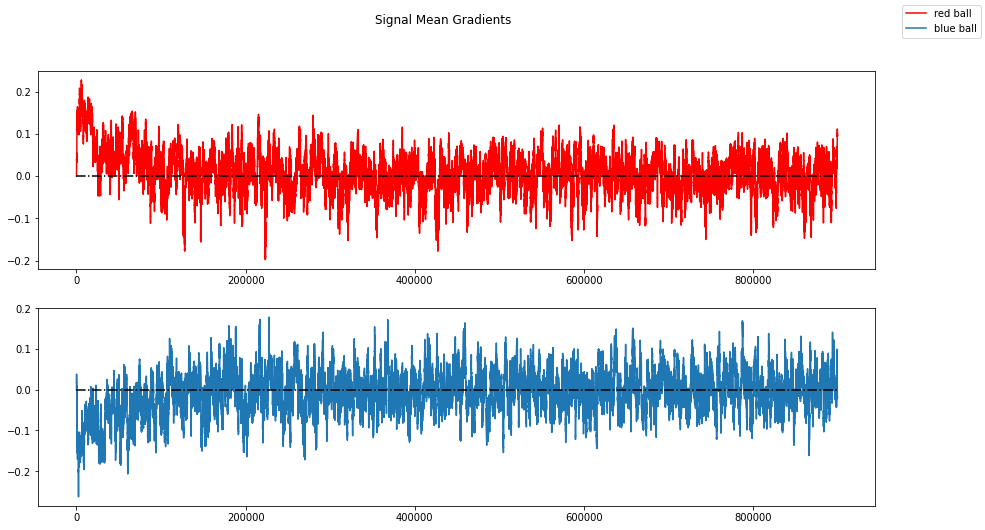

In [101]:
fig, axs = plt.subplots(2, figsize=(15, 8))
axs[0].plot(grad_r_ball_mean_history, 'r', label = 'red ball', zorder=-100)
axs[1].plot(grad_b_ball_mean_history,label = 'blue ball', zorder=-100)
axs[0].hlines(y=0, xmin=0, xmax=grad_r_ball_mean_history.shape[0], colors='black', linestyles='dashdot')
axs[1].hlines(y=0, xmin=0, xmax=grad_b_ball_mean_history.shape[0], colors='black', linestyles='dashdot')
# for coord in phase_change_coordinates(mark_index, pd.DataFrame(grad_r_ball_mean_history)):
#     axs[0].annotate('change', xy=coord, xytext=(coord[0], coord[1] + 0.05), arrowprops=dict(arrowstyle="->"))
# for coord in phase_change_coordinates(mark_index, pd.DataFrame(grad_b_ball_mean_history)):
#     axs[1].annotate('change', xy=coord, xytext=(coord[0], coord[1] - 0.05), arrowprops=dict(arrowstyle="->"))  
fig.legend()
fig.suptitle('Signal Mean Gradients')

Text(0.5, 0.98, 'Signal Mean Gradients (momentum)')

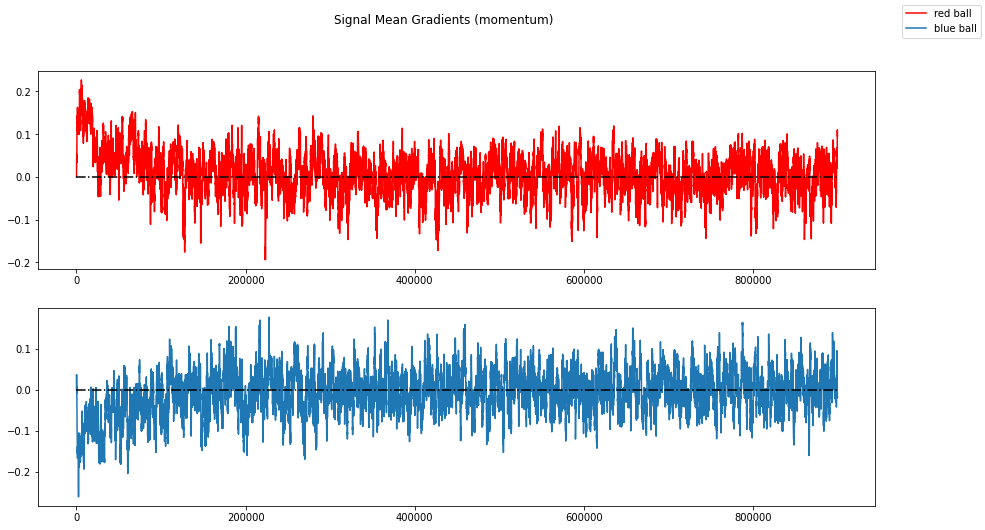

In [102]:
fig, axs = plt.subplots(2, figsize=(15, 8))
axs[0].plot(grad_r_ball_v_mean_history, 'r', label = 'red ball', zorder=-100)
axs[1].plot(grad_b_ball_v_mean_history,label = 'blue ball', zorder=-100)
axs[0].hlines(y=0, xmin=0, xmax=grad_r_ball_v_mean_history.shape[0], colors='black', linestyles='dashdot')
axs[1].hlines(y=0, xmin=0, xmax=grad_b_ball_v_mean_history.shape[0], colors='black', linestyles='dashdot')
fig.legend()
fig.suptitle('Signal Mean Gradients (momentum)')

Text(0.5, 0.98, 'Signal Mean Gradients (Adam)')

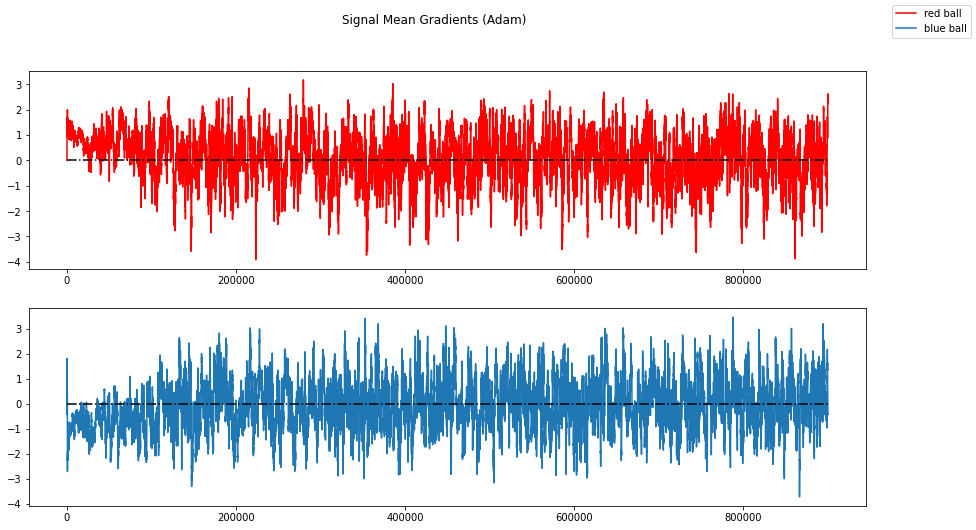

In [103]:
fig, axs = plt.subplots(2, figsize=(15, 8))
axs[0].plot(grad_r_ball_adam_mean_history, 'r', label = 'red ball', zorder=-100)
axs[1].plot(grad_b_ball_adam_mean_history,label = 'blue ball', zorder=-100)
axs[0].hlines(y=0, xmin=0, xmax=grad_r_ball_v_mean_history.shape[0], colors='black', linestyles='dashdot')
axs[1].hlines(y=0, xmin=0, xmax=grad_b_ball_v_mean_history.shape[0], colors='black', linestyles='dashdot')
fig.legend()
fig.suptitle('Signal Mean Gradients (Adam)')

In [104]:
# fig, axs = plt.subplots(2, figsize=(15, 8))
# axs[0].plot(grad_r_ball_mean_history[:, 2], 'r', label = 'red ball', zorder = -100)
# axs[1].plot(grad_b_ball_mean_history[:, 2],label = 'blue ball', zorder = -100)
# axs[0].hlines(y=0, xmin=0, xmax=grad_r_ball_mean_history.shape[0], colors='black', linestyles='dashdot')
# axs[1].hlines(y=0, xmin=0, xmax=grad_b_ball_mean_history.shape[0], colors='black', linestyles='dashdot')
# fig.legend()
# fig.suptitle('Prior Mean Gradient')

In [105]:
# fig, axs = plt.subplots(2, figsize=(15, 8))
# axs[0].plot(grad_r_ball_v_mean_history[:, 2], 'r', label = 'red ball', zorder = -100)
# axs[1].plot(grad_b_ball_v_mean_history[:, 2],label = 'blue ball', zorder = -100)
# axs[0].hlines(y=0, xmin=0, xmax=grad_r_ball_v_mean_history.shape[0], colors='black', linestyles='dashdot')
# axs[1].hlines(y=0, xmin=0, xmax=grad_b_ball_v_mean_history.shape[0], colors='black', linestyles='dashdot')
# fig.legend()
# fig.suptitle('Prior Mean Gradient (Momentum)')